In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv('./mhDataset.csv', index_col=0)

In [ ]:
df.dropna(inplace = True)

In [ ]:
import nltk
nltk.download('punkt_tab')
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)
df['statement']=df['original_statement'].str.lower()

In [ ]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)

In [ ]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)

In [ ]:
lemmatizer=WordNetLemmatizer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(lemmatizer.lemmatize(token,pos="v") for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

In [ ]:
# Get the English stopword set
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a space-separated string
def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

# Apply the function to the 'tokens_stemmed' column
df['tokens_stemmed'] = df['tokens_stemmed'].apply(remove_stopwords)

In [ ]:
from collections import Counter

class_counts = {
    'Depression': 15404,
    'Normal': 16343,
    'Anxiety': 3841,
    'Bipolar': 2777,
    'Stress': 2587,
    'Personality disorder': 1077
}

total_samples = sum(class_counts.values())
num_classes = len(class_counts)

class_weights = {
    cls: total_samples / (num_classes * count)
    for cls, count in class_counts.items()
}

print(class_weights)

{'Depression': 0.4547411927637843, 'Normal': 0.42861367761936814, 'Anxiety': 1.8237004252364835, 'Bipolar': 2.5224462849597886, 'Stress': 2.707705192629816, 'Personality disorder': 6.504023522129372}


In [ ]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

In [ ]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [ ]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [ ]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [ ]:
# Calculate sample weights based on the class_weights dictionary and the resampled training labels
sample_weights = np.array([class_weights[lbl_enc.inverse_transform([label])[0]] for label in y_train_resampled])

In [ ]:
# Define your models
models = {
    'XGB': XGBClassifier(
        learning_rate=0.2,
        max_depth=7,
        n_estimators=500,
        random_state=101,
        tree_method='gpu_hist', # Added GPU parameter back
        objective='multi:softprob',
        num_class=6  # 6
    )
}



For XGB
Accuracy: 0.8896026647632643
                      precision    recall  f1-score   support

             Anxiety       0.84      0.84      0.84       790
             Bipolar       0.83      0.84      0.84       543
          Depression       0.95      0.91      0.93      3014
              Normal       0.94      0.92      0.93      3313
Personality disorder       0.65      0.76      0.70       232
              Stress       0.58      0.81      0.68       514

            accuracy                           0.89      8406
           macro avg       0.80      0.85      0.82      8406
        weighted avg       0.90      0.89      0.89      8406



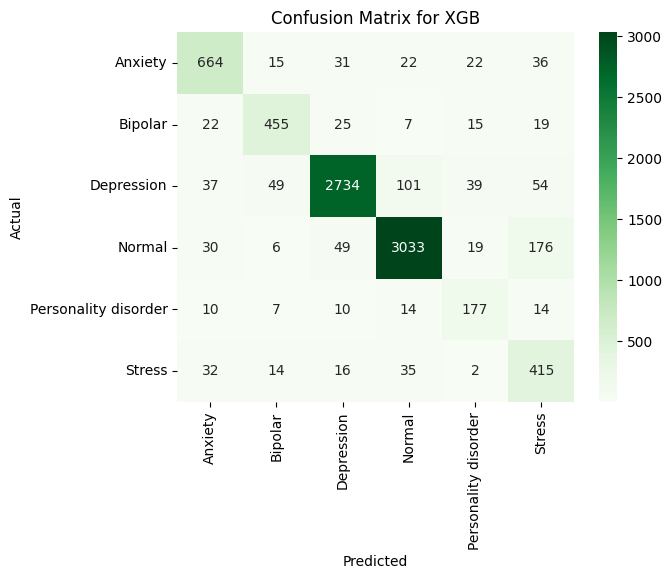

In [ ]:
# Initialize a list to store accuracy scores for each classifier
accuracy_scores = []

# Iterate over each classifier and its name in the models dictionary
for name, clf in models.items():
    # Fit the model with the calculated sample weights
    clf.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)

    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)

    # Compute the confusion matrix for the predictions
    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))

    # Plot the confusion matrix using a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Append the accuracy score to the list
    accuracy_scores.append(accuracy)

In [ ]:
def predict_mental_health_status(text, model, vectorizer, label_encoder):
    """
    Predicts the mental health status based on user input text.

    Args:
        text (str): The user input text.
        model: The trained machine learning model (e.g., tuned XGBoost model).
        vectorizer: The fitted TF-IDF vectorizer.
        label_encoder: The fitted label encoder for the status classes.

    Returns:
        str: The predicted mental health status.
    """
    # Preprocess the input text
    processed_text = text.lower()
    processed_text = remove_patterns(processed_text) # Assuming remove_patterns is defined
    tokens = word_tokenize(processed_text) # Assuming word_tokenize is defined
    lemmatizer = WordNetLemmatizer() # Assuming WordNetLemmatizer is defined
    stemmed_tokens = ' '.join(lemmatizer.lemmatize(token, pos="v") for token in tokens)
    processed_text = remove_stopwords(stemmed_tokens) # Assuming remove_stopwords is defined

    # Calculate numerical features
    num_of_characters = len(text)
    num_of_sentences = len(nltk.sent_tokenize(text)) # Assuming nltk is imported and punkt is downloaded

    # Vectorize the processed text
    text_tfidf = vectorizer.transform([processed_text])

    # Combine with numerical features
    input_combined = hstack([text_tfidf, np.array([[num_of_characters, num_of_sentences]])])

    # Predict the class
    prediction = model.predict(input_combined)

    # Decode the predicted class
    predicted_status = label_encoder.inverse_transform(prediction)

    return predicted_status[0]

# Example usage:
user_input = "I am feeling very sad and lonely these days."
predicted_status = predict_mental_health_status(user_input, clf, vectorizer, lbl_enc)
print(f"The predicted mental health status is: {predicted_status}")

user_input_2 = "I am very happy and excited about my new job."
predicted_status_2 = predict_mental_health_status(user_input_2, clf, vectorizer, lbl_enc)
print(f"The predicted mental health status is: {predicted_status_2}")

The predicted mental health status is: Depression
The predicted mental health status is: Normal


In [ ]:
import pickle

# Save the trained model
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

# Save the TF-IDF vectorizer
with open('xgb_tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save the label encoder
with open('xgb_label_encoder.pkl', 'wb') as f:
    pickle.dump(lbl_enc, f)

print("Model, vectorizer, and label encoder saved successfully.")

Model, vectorizer, and label encoder saved successfully.
